## Objetivo
Investigar o defeito de desbalanceamento usando análises comparativas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [2]:
df = pd.read_csv('../data.csv')
# separa apenas amostras com condicao de DESBALANCEAMENTO
df =  df.query("condicao == 'imbalance' or condicao == 'normal'")
# descarta a coluna 'condicao', agora redundante
df.pop('condicao')
# reinicia o index
df = df.reset_index(drop=True)
# descarta a coluna 'rotacao_manual' pois a velocidade extraída do tacometro representa melhor o rotor
df.pop('rotacao_manual')

print('Amostras: {} \nColunas: {}'.format(df.shape[0], df.shape[1]))

Amostras: 382 
Colunas: 66


In [3]:
# isola o acelerômetro um, sentido tangencial
df_tg1 = df[['severidade', 'rotacao_calc', 'tg1_1h', 'tg1_rms']]
df_tg1.head()

,severidade,rotacao_calc,tg1_1h,tg1_rms
0,10.0,13.6,0.904517,4.216448
1,10.0,14.2,0.973578,4.663037
2,10.0,15.4,1.278641,5.468684
3,10.0,16.2,2.055724,5.843787
4,10.0,16.8,2.372027,6.815680


In [4]:
df_tg1['severidade'].value_counts()

0.0     49
20.0    49
6.0     49
15.0    48
10.0    48
30.0    47
25.0    47
35.0    45
Name: severidade, dtype: int64

## Variação em função da velocidade

Primeiramente, será tomada a amostra com maior severidade de desbalanceamento (35g)

In [5]:
df_tg1_35g = df_tg1.query("severidade == 35")
df_tg1_35g.pop('severidade')
df_tg1_35g = df_tg1_35g.melt(id_vars='rotacao_calc')
df_tg1_35g

,rotacao_calc,variable,value
0,11.8,tg1_1h,1.321194
1,13.4,tg1_1h,2.172885
2,14.2,tg1_1h,3.882149
3,15.4,tg1_1h,6.431581
4,16.2,tg1_1h,8.624050
...,...,...,...
85,51.2,tg1_rms,103.331483
86,51.6,tg1_rms,102.515727
87,53.2,tg1_rms,102.318904
88,53.8,tg1_rms,101.358212


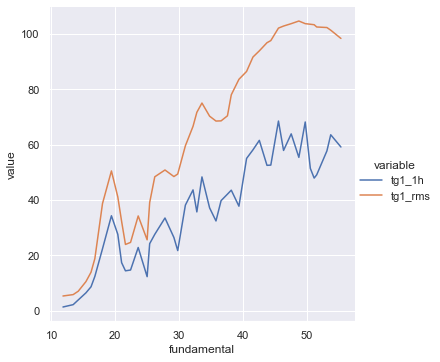

In [6]:
sns.relplot(data=df_tg1_35g, x='rotacao_calc', y='value', hue='variable', kind='line');

<AxesSubplot:xlabel='rotacao_calc', ylabel='value'>

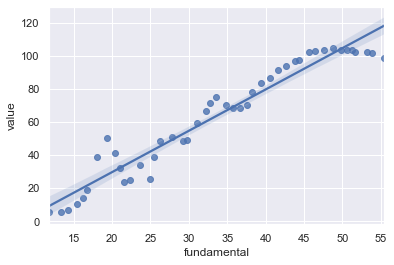

In [7]:
sns.regplot(data=df_tg1_35g.query("variable == 'tg1_rms'"), x='rotacao_calc', y='value')

Como exposto, o nível de vibração tende a crescer linearmente com a velocidade de rotação. No entanto, há um comportamento estranho próximo à 20 Hz. 
No eixo tangencial, mas desta vez no acelerômetro 2, o comportamento se repete, indicando uma possível velocidade de ressonância.

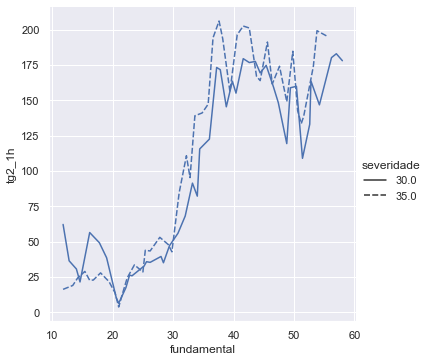

In [8]:
sns.relplot(
    data=df[['severidade', 'rotacao_calc', 'tg2_1h']].query("severidade == 35 | severidade == 30"),
    x='rotacao_calc', y='tg2_1h', style='severidade', kind='line'
);

Desta vez, verificamos que ele de fato ocorre com todos os graus de seeveridade.

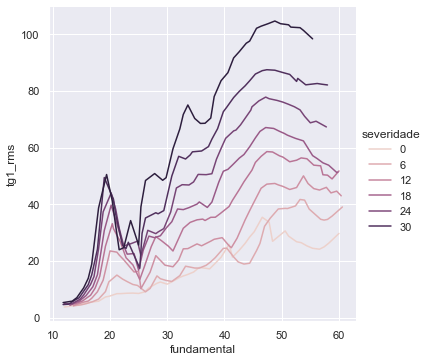

In [9]:
sns.relplot(data=df_tg1.drop('tg1_1h', axis=1), x='rotacao_calc', y='tg1_rms', hue='severidade', kind='line');

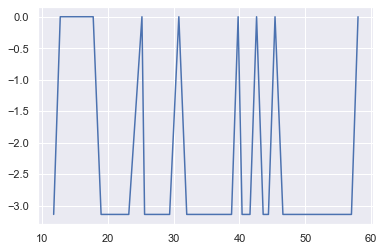

In [10]:
def unwrap_deg(degrees):
    return np.rad2deg(np.unwrap(np.deg2rad(degrees)))

plt.plot(df.query('severidade == 30')['rotacao_calc'], df.query('severidade == 30')['tg1_phase'])

Quando mudamos o eixo para o radial, por exemplo, o comportamento se repete, mas no patamar próximo de 25 Hz

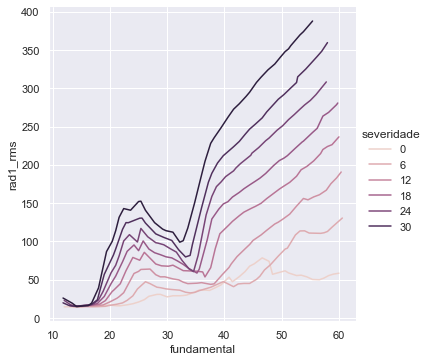

In [11]:
sns.relplot(
    data=df[['severidade', 'rotacao_calc', 'rad1_rms']],
    x='rotacao_calc', y='rad1_rms', hue='severidade', kind='line'
);

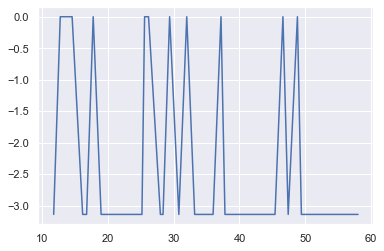

In [12]:
plt.plot(df.query('severidade == 30')['rotacao_calc'], df.query('severidade == 30')['rad1_phase'])

# Variação em função da severidade (fixada a velocidade)

In [13]:
print('Representantes: ')

for severidade in df_tg1['severidade'].unique():
    subset = df_tg1.query('severidade == {}'.format(severidade))
    print('    {:2.0F} g -'.format(severidade), subset['rotacao_calc'].iloc[44])


Representantes: 
    10 g - 57.8
    15 g - 57.2
    20 g - 56.2
    25 g - 55.0
    30 g - 56.2
    35 g - 55.400000000000006
     6 g - 56.8
     0 g - 56.6


In [14]:
# seleciona representates na faixa desejada
df_tg1_55hz = df_tg1.query("rotacao_calc > 54.8 & rotacao_calc < 56.4").drop([140, 190])
df_tg1_55hz.pop('rotacao_calc')

# tabula de forma cumprida
df_tg1_55hz = df_tg1_55hz.melt(id_vars='severidade')

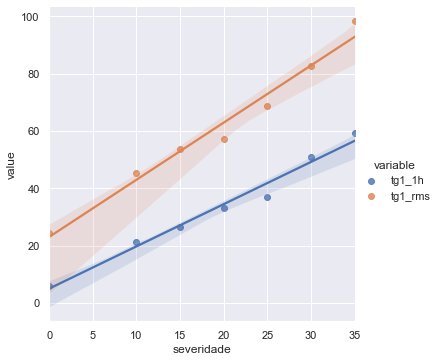

In [15]:
sns.lmplot(data=df_tg1_55hz, x='severidade', y='value', hue='variable');

Nota-se uma relação linear entre a vibração no eixo tangencial e o grau de severidade do desbalanceamento.
Este comportamento se repete para todas as velocidades?

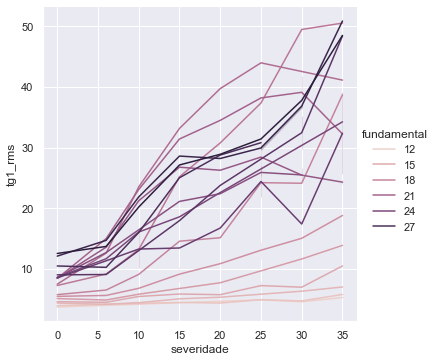

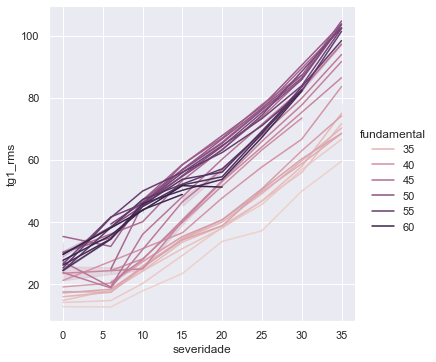

In [16]:
df_tg1_round = df_tg1.drop('tg1_1h', axis=1).copy(deep=True)
df_tg1_round['rotacao_calc'] = df_tg1['rotacao_calc'].apply(round)

sns.relplot(
    data=df_tg1_round.query('rotacao_calc < 30'), 
    x='severidade', y='tg1_rms', hue='rotacao_calc', kind='line',
);

sns.relplot(
    data=df_tg1_round.query('rotacao_calc > 30'), 
    x='severidade', y='tg1_rms', hue='rotacao_calc', kind='line',
);

Em geral, para velocidades acima de 30 Hz o comportamento é linear. Abaixo de 30 Hz há certa desordem nos dados.

Em seguida, normalizamos os dados em relação à velocidade de rotação.

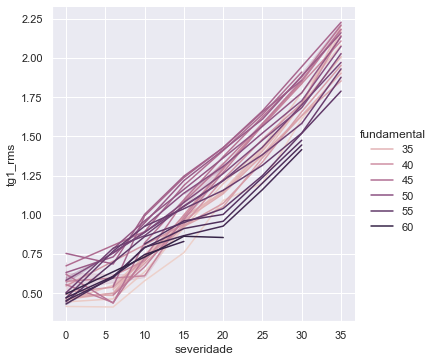

In [17]:
df_tg1_round_normalized = df_tg1_round.copy(deep=True)
df_tg1_round_normalized['tg1_rms'] = df_tg1_round['tg1_rms']/df_tg1_round['rotacao_calc']

sns.relplot(
    data=df_tg1_round_normalized.query('rotacao_calc > 30'), 
    x='severidade', y='tg1_rms', hue='rotacao_calc', kind='line',
);

A normalização melhora bastante a relação de linearidade entre as variáveis. No entando, ao se inverter os eixos, notamos a dificuldade de gerar um modelo adequado, que acerte a severidade de desbalanceamento, pois: 

1. A severidade é uma variavel muito discretizada
2. Em uma mesma faixa de velocidade, valores próximos de aceleraçao tangencial correspondem a severidades muito distintas

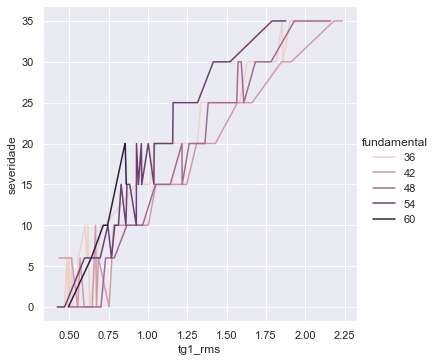

In [18]:
df_tg1_round_normalized = df_tg1_round.copy(deep=True)
df_tg1_round_normalized['tg1_rms'] = df_tg1_round['tg1_rms']/df_tg1_round['rotacao_calc']
df_tg1_round_normalized['rotacao_calc'] = df_tg1_round_normalized['rotacao_calc']//6*6

sns.relplot(
    data=df_tg1_round_normalized.query('rotacao_calc > 30'), 
    y='severidade', x='tg1_rms', hue='rotacao_calc', kind='line',
);

O ideal seria encurtar ainda mais a faixa de valores. Como se vê, a reta de regressão não permite uma função unívoca para cada valor de aceleração tangencial.

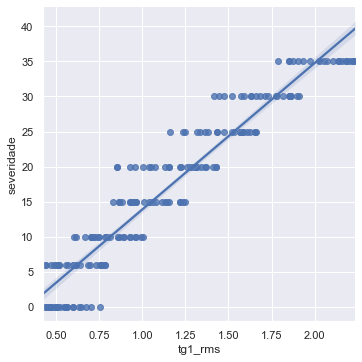

In [19]:
sns.lmplot(
    data=df_tg1_round_normalized.query('rotacao_calc > 30'), 
    y='severidade', x='tg1_rms'
);